# 03 Anomaly

![](https://images.unsplash.com/photo-1536303100418-985cb308bb38?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1050&q=80)

Picture by [Will Myers](https://unsplash.com/photos/ku_ttDpqIVc)

In this challenge, you will play again with the [Kaggle credit card fraud detection](https://www.kaggle.com/mlg-ulb/creditcardfraud). But this time, you will use AutoEncoder to perform the anomaly detection.

The idea of using an Autoencoder for anomaly detection is the following.

If you train an AutoEncoder on pure data (only normal class), then the AutoEncoder now knows the normal data. If you make predictions on new data, the following behavior is expected:
- The AutoEncoder sould be able to encode properly any normal data: the reconstruction error should be small
- The AutoEncoder has never seen anomaly data: the reconstruction error should be large

So basically, you will train an AutoEncoder on normal data only, and on the test dataset, you will use the reconstruction error as a way to discriminate.

Since you know well this dataset, the first part will be done easily: load the dataset, make a quick data exploration.

In [1]:
### TODO: Data exploration
### STRIP_START ###
import pandas as pd
import numpy as np

df = pd.read_csv('creditcard.csv')
df.head()
### STRIP_END ###

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
df = df.drop_duplicates()

In [3]:
df.shape

(283726, 31)

In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

You will want to use an AutoEncoder with input and output values only in the range (0, 1): so that you can use sigmoid functions. Thus, scale your data so that all your features are between 0 and 1

In [5]:
### TODO: use a scaler to scale your data between 0 and 1
### STRIP_START ###
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = scaler.fit_transform(df.drop(columns=['Time', 'Class']))

X = pd.DataFrame(X, columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'], index=df.index)

print(X.shape)
X.describe()
### STRIP_END ###

(283726, 29)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,0.958394,0.767215,0.837442,0.251799,0.765729,0.263008,0.265366,0.785376,0.462725,0.508692,...,0.580267,0.561474,0.510030,0.665437,0.382263,0.577894,0.425473,0.416543,0.313135,0.003444
std,0.033095,0.017375,0.026143,0.062690,0.009270,0.013391,0.007479,0.012648,0.037738,0.022270,...,0.008198,0.011670,0.033800,0.009263,0.081608,0.029257,0.078742,0.007305,0.006657,0.009747
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.942733,0.760924,0.821997,0.214244,0.761072,0.255288,0.261990,0.783145,0.440588,0.497641,...,0.578014,0.557799,0.484714,0.663032,0.334472,0.560085,0.372072,0.415207,0.312052,0.000218
50%,0.958640,0.767933,0.840532,0.250944,0.765356,0.260253,0.265604,0.785620,0.460968,0.506793,...,0.579601,0.561005,0.510342,0.665268,0.387761,0.578820,0.416926,0.416538,0.313353,0.000856
75%,0.980652,0.775703,0.855209,0.284718,0.769838,0.267009,0.268831,0.788879,0.483310,0.518107,...,0.581684,0.564481,0.534674,0.667628,0.441489,0.597590,0.464695,0.418194,0.314712,0.003017
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As usual, create an `X` and `y` variables, and split the dataset into train and test datasets. 

In [6]:
### TODO: Create your train and test dataset
### STRIP_START ###
df['Time_day'] = df['Time'].apply(lambda x : x/ 3600 %24)
df['Time_day'] = df['Time_day']/24.
### STRIP_END ###

In [7]:
X = pd.concat([X, df['Time_day']], axis=1)
X.shape

(283726, 30)

In [8]:
y = df['Class']
y.shape, y.unique()

((283726,), array([0, 1]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [10]:
X_train.shape, X_test.shape

((226980, 30), (56746, 30))

In [11]:
X_train_pure = X_train[y_train==0]
X_train_pure.shape

(226602, 30)

Now build an AutoEncoder, and fit it on the train dataset (with removed anomalous data)

In [40]:
### TODO: Build and fit your AutoEncoder
### STRIP_START ###
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

latent_dim = 64

# define the input layer: the pixel values
input_data = Input(shape=(X.shape[1],))

# encode
encoded = Dense(latent_dim, activation='relu')(input_data)
encoded = Dense(latent_dim/2, activation='relu')(encoded)

# decode
decoded = Dense(latent_dim, activation='relu')(encoded)
decoded = Dense(X.shape[1], activation='sigmoid')(decoded)

# Define the autoencoder model
autoencoder = Model(input_data, decoded)

# Define de encoder model
encoder = Model(input_data, encoded)

# Define de decoder model
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(latent_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
### STRIP_END ###

In [41]:
autoencoder.compile(optimizer='adam', loss='mse')

batch_size = 128

autoencoder.fit(X_train_pure, X_train_pure,
                epochs=100,
                batch_size=batch_size,
                validation_data=(X_test, X_test))

Train on 226602 samples, validate on 56746 samples
Epoch 1/100
226602/226602 [==============================] - 3s 15us/sample - loss: 0.0016 - val_loss: 5.2275e-04
Epoch 2/100
226602/226602 [==============================] - 3s 13us/sample - loss: 3.0997e-04 - val_loss: 2.8320e-04
Epoch 3/100
226602/226602 [==============================] - 3s 13us/sample - loss: 2.2453e-04 - val_loss: 1.9707e-04
Epoch 4/100
226602/226602 [==============================] - 3s 13us/sample - loss: 1.3908e-04 - val_loss: 1.4274e-04
Epoch 5/100
226602/226602 [==============================] - 3s 13us/sample - loss: 1.0640e-04 - val_loss: 1.1246e-04
Epoch 6/100
226602/226602 [==============================] - 3s 13us/sample - loss: 8.4913e-05 - val_loss: 8.7367e-05
Epoch 7/100
226602/226602 [==============================] - 3s 15us/sample - loss: 6.5886e-05 - val_loss: 6.4558e-05
Epoch 8/100
226602/226602 [==============================] - 4s 17us/sample - loss: 5.1238e-05 - val_loss: 5.3991e-05
Epoch 9/1

226602/226602 [==============================] - 3s 14us/sample - loss: 1.4580e-05 - val_loss: 1.8341e-05
Epoch 70/100
226602/226602 [==============================] - 3s 13us/sample - loss: 1.4502e-05 - val_loss: 1.8034e-05
Epoch 71/100
226602/226602 [==============================] - 3s 15us/sample - loss: 1.4506e-05 - val_loss: 1.8445e-05
Epoch 72/100
226602/226602 [==============================] - 4s 19us/sample - loss: 1.4447e-05 - val_loss: 1.9414e-05
Epoch 73/100
226602/226602 [==============================] - 4s 18us/sample - loss: 1.4403e-05 - val_loss: 1.7323e-05
Epoch 74/100
226602/226602 [==============================] - 3s 13us/sample - loss: 1.4374e-05 - val_loss: 1.7367e-05
Epoch 75/100
226602/226602 [==============================] - 3s 12us/sample - loss: 1.4331e-05 - val_loss: 1.9866e-05
Epoch 76/100
226602/226602 [==============================] - 3s 12us/sample - loss: 1.4346e-05 - val_loss: 1.9026e-05
Epoch 77/100
226602/226602 [==============================] -

Once the AutoEncoder is trained, compute the mean squared error between the features `X_train` and the predicted features from the AutoEncoder.

In [42]:
### TODO: Compute the MSE
### STRIP_START ###
X_train_pred = autoencoder.predict(X_train)
### STRIP_END ###

In [43]:
from sklearn.metrics import mean_squared_error

train_error = np.array([mean_squared_error(gt, pred) for gt,pred in zip(X_train.values, X_train_pred)])

Display the mean squared error on a scatter plot (or an histogram) with different colors for the classes.

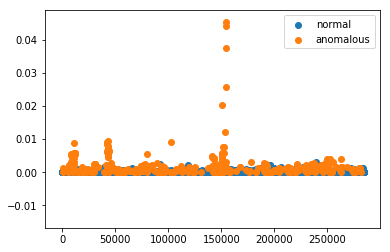

In [44]:
### TODO: Display the errors
### STRIP_START ###
import matplotlib.pyplot as plt

plt.scatter((X_train[y_train==0]).index, train_error[y_train==0], label='normal')
plt.scatter((X_train[y_train==1]).index, train_error[y_train==1], label='anomalous')

plt.legend()
plt.show()
### STRIP_END ###

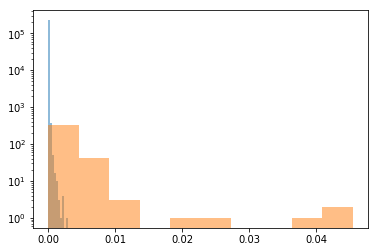

In [45]:
import matplotlib.pyplot as plt

plt.hist(train_error[y_train==0], log=True, alpha=0.5)
plt.hist(train_error[y_train==1], log=True, alpha=0.5)
plt.show()

Is there a difference in the error between normal and abnormal data?

Now, using the mean squared error on the test dataset, compute the AUPRC (Area Under Precision Recall Curve) and the Precision Recall Curve.

In [46]:
### TODO: Compute and display the AUPRC
### STRIP_START ###
X_test_pred = autoencoder.predict(X_test)
test_error = np.array([mean_squared_error(gt, pred) for gt,pred in zip(X_test.values, X_test_pred)])
### STRIP_END ###

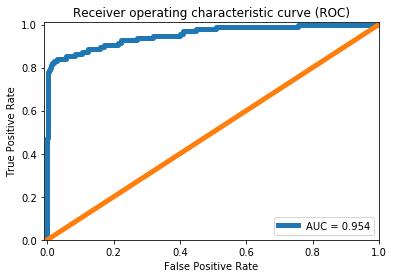

In [48]:
# AUC
from sklearn.metrics import roc_curve, auc

false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, test_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

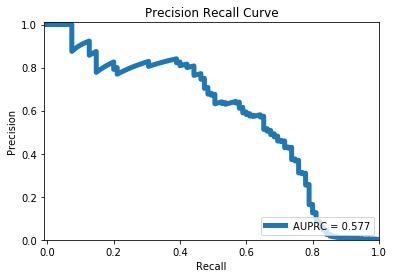

In [49]:
# AUPRC
from sklearn.metrics import precision_recall_curve

precision , recall, threshold = precision_recall_curve(y_test, test_error)
auprc = auc(recall, precision)


plt.plot(recall, precision, linewidth=5, label='AUPRC = %0.3f'% auprc)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Precision Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

If you are curious, you can also have a look at the latent distributions, as a function of the class.

In [51]:
X_train_latent = encoder.predict(X_train)

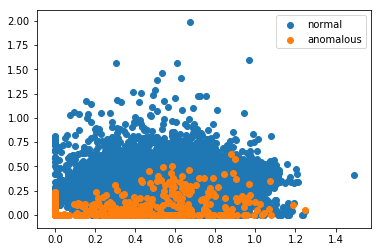

In [54]:

plt.scatter(X_train_latent[y_train==0, 0], X_train_latent[y_train==0, 2], label='normal')
plt.scatter(X_train_latent[y_train==1, 0], X_train_latent[y_train==1, 2], label='anomalous')

plt.legend()
plt.show()